In [1]:
import sys
sys.path.append("../../../")

In [2]:
from pylib.utils.functions_for_regression import lin_data, plot_scatter
import matplotlib.pyplot as plt
import numpy as np

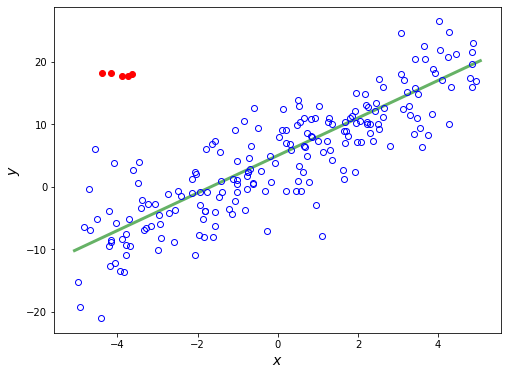

In [3]:
X, y, _, f_truth, outliers = lin_data(200, has_outlier=True)

plt.figure(figsize=(8, 6))
plot_scatter(X, y, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
plt.show()

In [4]:
X_ol = np.r_[X, outliers[:, 0].reshape(-1, 1)]
y_ol = np.r_[y, outliers[:, 1]]

## 绝对值偏差回归

In [5]:
import ipyvolume.pylab as plt3d

### 绝对值偏差

In [6]:
def least_absolute_deviation(X, W, y):
    loss = np.sum(np.abs(y - X @ W))
    return loss

### 迭代再加权最小二乘

In [7]:
def IRLS(X, y, epochs=200):
    n, p = X.shape
    W = np.random.randn(p)
    weight_history = [W.copy()]
    loss = least_absolute_deviation(X, W, y)
    loss_history = [loss]
    tol = 1e-8
    for e in range(1, epochs+1):
        if e <= 1 or e % 10 == 0:
            print("epoch={}, loss={}".format(e, loss))
        D = np.diag(1 / np.abs(y - X @ W))
        W = np.linalg.inv(X.T @ D @ X) @ (X.T @ D @ y)  # 更新权重
        weight_history.append(W.copy())
        weights_diff = np.sum(np.abs(weight_history[-1] - weight_history[-2]))
        if weights_diff < tol or loss < tol:
            break
        loss = least_absolute_deviation(X, W, y)
        loss_history.append(loss)
        
    return weight_history, loss_history

In [8]:
X_ol_b = np.c_[np.ones(len(X_ol)), X_ol]
weight_history, loss_history = IRLS(X_ol_b, y_ol, epochs=100)

epoch=1, loss=2173.8171586099415
epoch=10, loss=875.1549821518569
epoch=20, loss=866.4864401731918
epoch=30, loss=865.3318452154051
epoch=40, loss=865.2680315922785
epoch=50, loss=865.2407826954345
epoch=60, loss=865.2036173013614
epoch=70, loss=865.1787380039073
epoch=80, loss=865.1766344577492


In [9]:
W = weight_history[-1]
W

array([4.30239653, 3.0657646 ])

### 成本函数历史

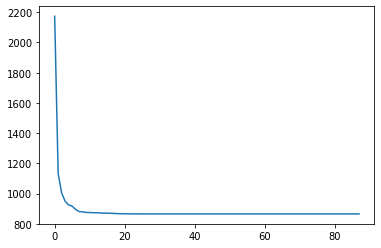

In [10]:
plt.plot(range(len(loss_history)), loss_history)
plt.show()

### 参数空间与优化路径

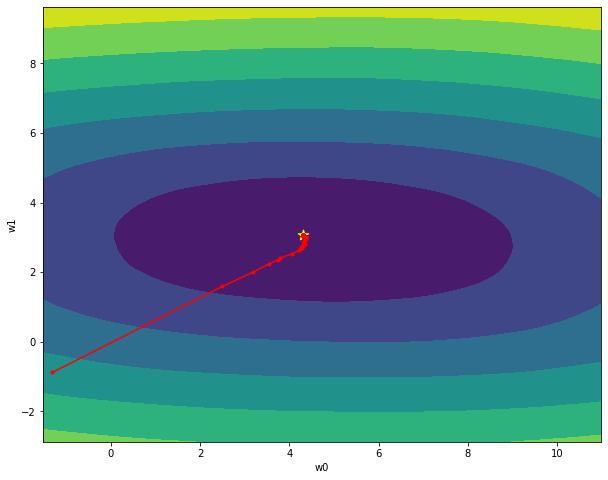

In [11]:
max_interval = np.abs(np.max(weight_history) - np.min(weight_history))
w0n_min = W[0] - max_interval
w0n_max = W[0] + max_interval
w1n_min = W[1] - max_interval
w1n_max = W[1] + max_interval
w0n = 1.1 * np.linspace(w0n_min, w0n_max, 300)
w1n = 1.1 * np.linspace(w1n_min, w1n_max, 300)
ww0n, ww1n = np.meshgrid(w0n, w1n)
Wn = np.c_[ww0n.ravel(), ww1n.ravel()]
lossn = np.array([least_absolute_deviation(X_ol_b, w, y_ol) for w in Wn]).reshape(ww0n.shape)
w0_path = np.array([w[0] for w in weight_history])
w1_path = np.array([w[1] for w in weight_history])

plt.figure(figsize=(10, 8))
plt.contourf(ww0n, ww1n, lossn)
plt.plot(w0_path, w1_path, ".-", c='r')
plt.scatter(W[0], W[1], c='yellow', marker='*', s=120)
plt.xlabel("w0")
plt.ylabel("w1")
plt.show()

In [12]:
plt3d.figure(width=1000, height=500)
plt3d.plot_surface(ww0n, lossn, ww1n, color="green")
plt3d.scatter(w0_path.ravel(), np.array(loss_history).ravel(), w1_path.ravel(),
              marker='sphere', size=1.5)
plt3d.plot(w0_path.ravel(), np.array(loss_history).ravel(), w1_path.ravel())
plt3d.scatter(np.array([W[0]]), np.array([loss_history[-1]]), np.array([W[1]]), 
              color='yellow', size=3)
plt3d.xlabel("w0")
plt3d.zlabel("w1")
plt3d.ylabel("mse")
plt3d.show()

### 拟合线

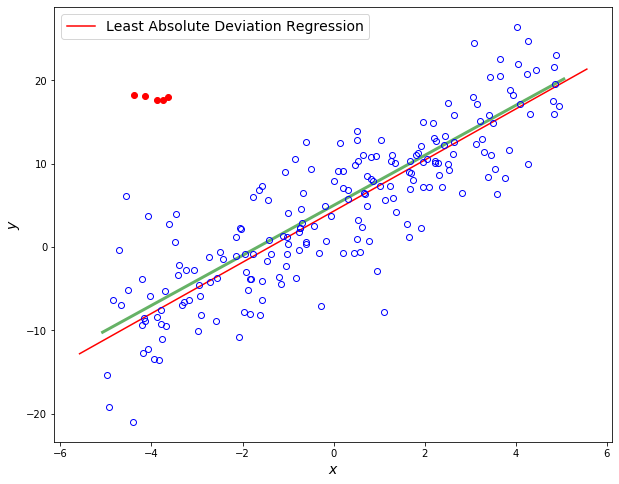

In [13]:
plt.figure(figsize=(10, 8))
plot_scatter(X, y, f=f_truth)
plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
xn = np.linspace(plt.xlim()[0], plt.xlim()[1], 100)
yn = W[0] + W[1] * xn
plt.plot(xn, yn, "r", label="Least Absolute Deviation Regression")
plt.legend(fontsize=14)
plt.show()